### Importing Libraries

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import os

import seaborn as sns

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

%run helpFunction.ipynb

\begin{table}
\caption{Test Klassifikations Metriken}
\label{tab:model_performance}
\begin{tabular}{llllr}
\toprule
Modell & Accuracy & Precision & Recall & F1-Score \\
\midrule
ViT & 83\% & 83\% & 83\% & 83.000000 \\
Hybridmodel - ViT - DeiT & 82\% & 82\% & 82\% & 82.000000 \\
Hybridmodel - ViT Lite - DeiT & 82\% & 82\% & 82\% & 82.000000 \\
InceptionV3 & 82\% & 83\% & 82\% & 82.000000 \\
DeiT & 81\% & 81\% & 82\% & 81.000000 \\
ViT Lite & 79\% & 79\% & 79\% & 79.000000 \\
Basic CNN & 78\% & 80\% & 78\% & 78.000000 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/rg/wpq9g3gn2_sg42m9vzpp7flw0000gn/T/ipykernel_2214/1995663629.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Modell').apply(lambda x: x.nlargest(1, 'F1-Score')).reset_index(drop=True)


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
wandb.init(project="VisionTransformer")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: silvan-wiedmer (silvan-wiedmer-fhgr). Use `wandb login --relogin` to force relogin


### Konfiguration Settings

In [4]:
image_size = (250, 250)
batch_size = 32

### Data Preprocessing

In [5]:
path_with_sign = '../data/y'
path_without_sign = '../data/n'

In [6]:
#Canny edge detection
def apply_canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    tight = cv2.Canny(blurred, 140, 160)
    tight = cv2.resize(tight, image_size)
    tight = np.expand_dims(tight, axis=-1)
    
    return tight

In [7]:
#Morphology Methode wurde angwendet
def apply_morphology(image, target_size=(250, 250)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 190, 210, cv2.THRESH_BINARY)
    
    kernel = np.ones((5,5), np.uint8)
    
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    
    image = cv2.resize(eroded, target_size)
    image = np.expand_dims(image, axis=-1)
    return image

In [8]:
def black_and_white(image, target_size=(250, 250)):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, target_size)
    image = np.expand_dims(image, axis=-1)
    return image

In [9]:
def load_images_from_folder(folder, label, target_size, type='normal'):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:             
            img = cv2.imread(img_path)
            if type == 'canny':
                img = apply_canny(img)
            elif type == 'morphology':
                img = apply_morphology(img, target_size)
            elif type == 'normal':
                img = black_and_white(img, target_size)
            else:    
                raise ValueError(f"Unbekannter Typ '{type}'")
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Fehler beim Laden des Bildes {img_path}: {e}")
    return np.array(images), np.array(labels)

In [10]:
images_with_sign_canny, labels_with_sign_canny = load_images_from_folder(path_with_sign, 0, image_size, type='canny')
images_without_sign_canny, labels_without_sign_canny = load_images_from_folder(path_without_sign, 1, image_size, type='canny')

images_with_sign_morphology, labels_with_sign_morphology = load_images_from_folder(path_with_sign, 0, image_size, type='morphology')
images_without_sign_morphology, labels_without_sign_morphology = load_images_from_folder(path_without_sign, 1, image_size, type='morphology')

images_with_sign_normal, labels_with_sign_normal = load_images_from_folder(path_with_sign, 0, image_size, type='normal')
images_without_sign_normal, labels_without_sign_normal = load_images_from_folder(path_without_sign, 1, image_size, type='normal')


images_with_sign_canny = np.array(images_with_sign_canny)
images_without_sign_canny = np.array(images_without_sign_canny)
images_with_sign_morphology = np.array(images_with_sign_morphology)
images_without_sign_morphology = np.array(images_without_sign_morphology)
images_with_sign_normal = np.array(images_with_sign_normal)
images_without_sign_normal = np.array(images_without_sign_normal)

images_with_sign = np.concatenate((images_with_sign_canny, images_with_sign_morphology, images_with_sign_normal), axis=-1)
images_without_sign = np.concatenate((images_without_sign_canny, images_without_sign_morphology, images_without_sign_normal), axis=-1)
labels_with_sign = np.array(labels_with_sign_canny)
labels_without_sign = np.array(labels_without_sign_canny)

all_images = np.concatenate((images_with_sign, images_without_sign), axis=0)
all_labels = np.concatenate((labels_with_sign, labels_without_sign), axis=0)

print("Shape of all_images tensor:", all_images.shape)
print("Shape of all_labels tensor:", all_labels.shape)

Shape of all_images tensor: (1456, 250, 250, 3)
Shape of all_labels tensor: (1456,)


### Data Normalization

In [11]:
all_images = all_images.astype('float32') / 255.0
all_images.shape

(1456, 250, 250, 3)

In [12]:
namelabels = {0: 'Wartelinie', 1: 'keine Wartelinie'}
def show_image(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(namelabels[label])
    plt.show()

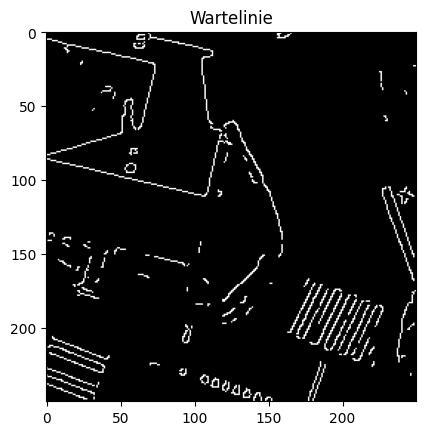

In [13]:
show_image(images_with_sign_canny[4], labels_with_sign_canny[4])

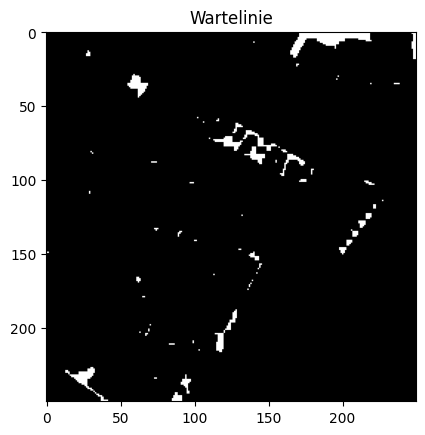

In [14]:
show_image(images_with_sign_morphology[3], labels_with_sign_morphology[3])

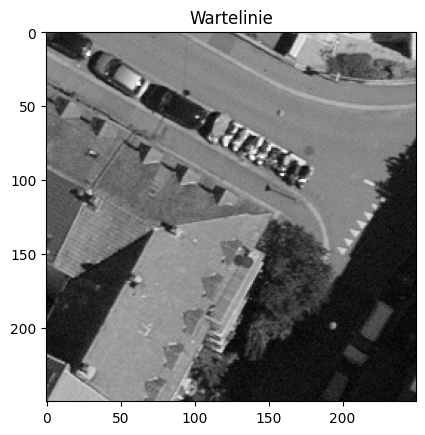

In [15]:
show_image(images_with_sign_normal[3], labels_with_sign_normal[3])

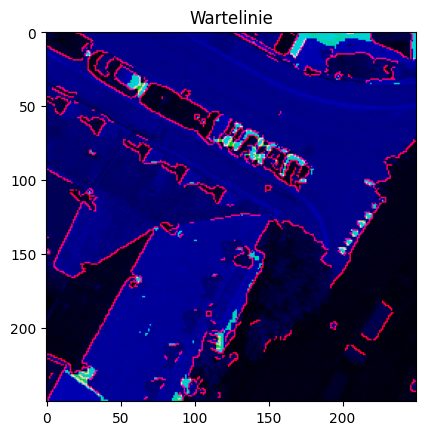

In [16]:
show_image(all_images[3], all_labels[3])

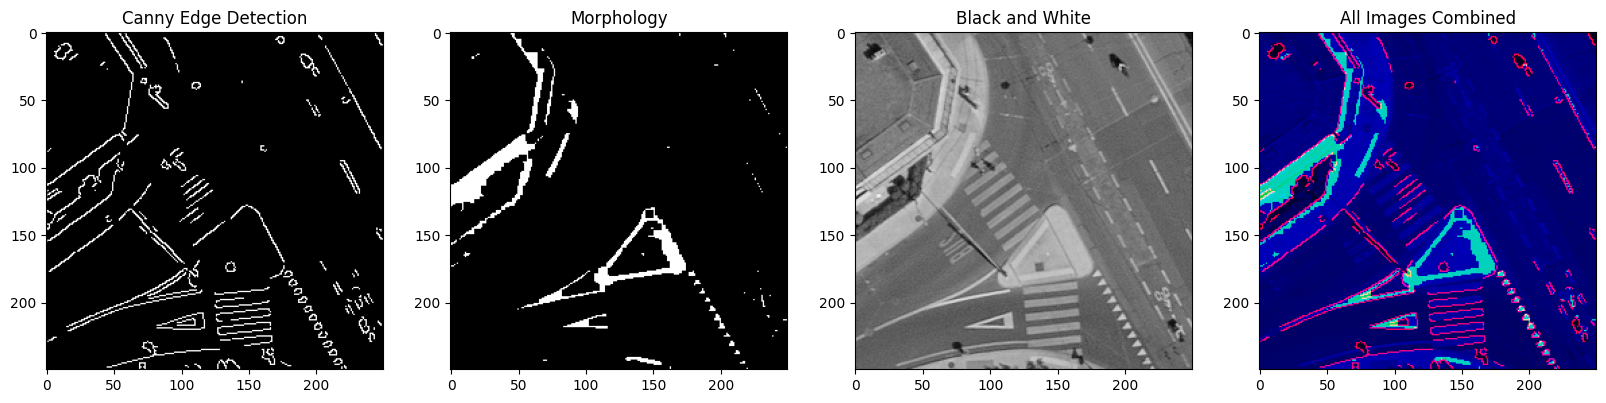

In [17]:

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(images_with_sign_canny[1], cmap='gray')
ax[0].set_title('Canny Edge Detection')

ax[1].imshow(images_with_sign_morphology[1], cmap='gray')
ax[1].set_title('Morphology')

ax[2].imshow(images_with_sign_normal[1], cmap='gray')
ax[2].set_title('Black and White')

ax[3].imshow(all_images[1], cmap='gray')
ax[3].set_title('All Images Combined')

plt.show()

### Data Splitting

In [18]:
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

In [19]:
train_images.shape, test_images.shape

((1164, 250, 250, 3), (292, 250, 250, 3))

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

In [21]:
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size)

### Vortrainiertes Modell

In [22]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=None)
base_model.trainable = False

2024-10-27 18:55:25.564049: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-27 18:55:25.564078: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-27 18:55:25.564085: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-27 18:55:25.564097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-27 18:55:25.564106: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x) 

In [24]:
model = Model(inputs=base_model.input, outputs=predictions)

In [25]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(
    train_images, train_labels,
    batch_size=batch_size,
    epochs=20,
    validation_split=0.10,
    callbacks=[WandbMetricsLogger()]
)

Epoch 1/20


2024-10-27 18:55:30.348668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 331ms/step - accuracy: 0.5156 - loss: 4.1068 - val_accuracy: 0.7265 - val_loss: 3.7439
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.6721 - loss: 3.8165 - val_accuracy: 0.6838 - val_loss: 3.7360
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7800 - loss: 3.6108 - val_accuracy: 0.7265 - val_loss: 3.6706
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.7795 - loss: 3.5545 - val_accuracy: 0.7350 - val_loss: 3.6308
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.8418 - loss: 3.4727 - val_accuracy: 0.7350 - val_loss: 3.6037
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.8237 - loss: 3.4312 - val_accuracy: 0.7521 - val_loss: 3.5318
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.8303 - loss: 3.3246 - val_accuracy: 0.7607 - val_loss: 3.4809
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.8551 - loss: 3.2940 - val_accuracy: 0.8291 - val

In [27]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Testgenauigkeit: {test_acc:.4f}, Testverlust: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 429ms/step - accuracy: 0.8203 - loss: 2.7999
Testgenauigkeit: 0.8219, Testverlust: 2.8034


In [28]:
wandb.log({"test_loss": test_loss, "test_acc": test_acc})

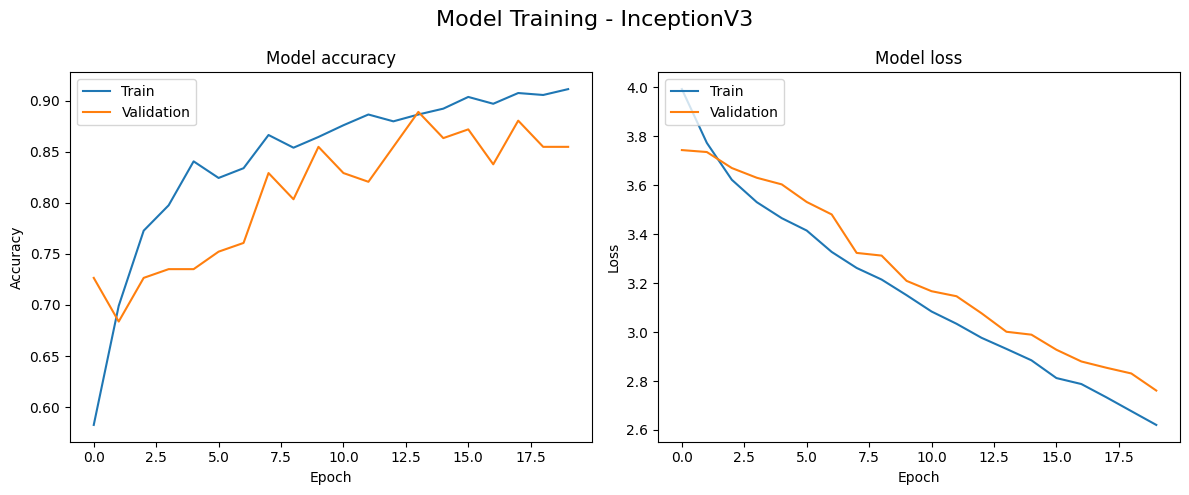

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.suptitle('Model Training - InceptionV3', fontsize=16)
plt.tight_layout()
plt.show()


In [30]:
predictions = model.predict(test_images)
predictions = (predictions > 0.5)

prediction_csv(test_labels, predictions, 'InceptionV3')

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 594ms/step
              precision    recall  f1-score     support
0              0.874016  0.755102  0.810219  147.000000
1              0.781818  0.889655  0.832258  145.000000
accuracy       0.821918  0.821918  0.821918    0.821918
macro avg      0.827917  0.822379  0.821239  292.000000
weighted avg   0.828233  0.821918  0.821163  292.000000
82.1917808219178
        Modell Accuracy Precision Recall F1-Score                       Date
0  InceptionV3      82%       83%    82%      82% 2024-10-27 18:57:33.984231


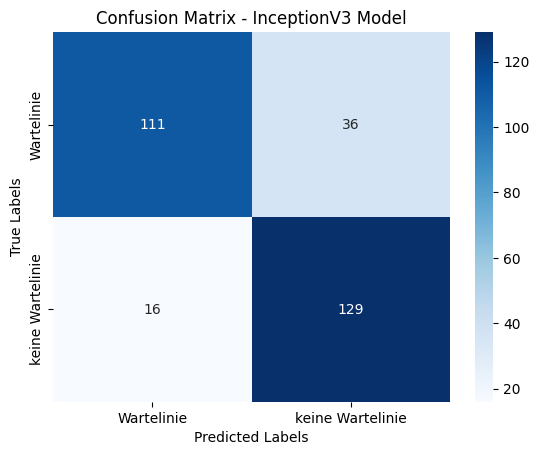

In [31]:
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=namelabels.values(), yticklabels=namelabels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - InceptionV3 Model')
wandb.log({"confusion-matrix": wandb.Image(plt)})
plt.show()

In [32]:
wandb.finish()

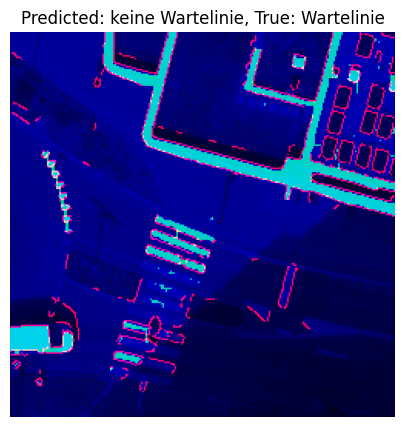

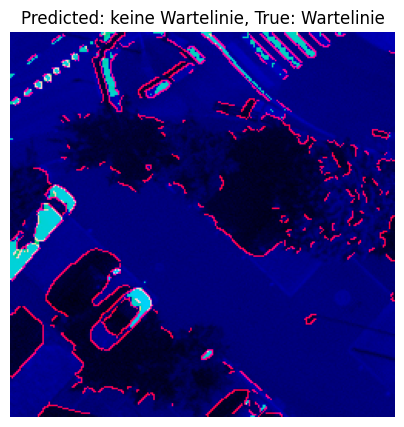

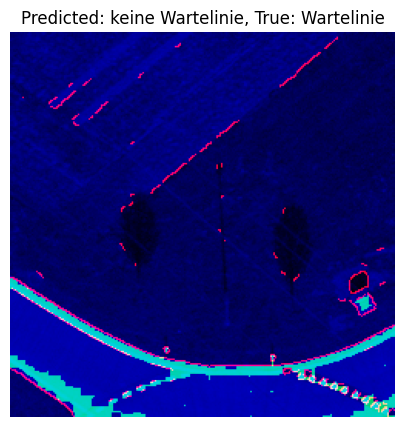

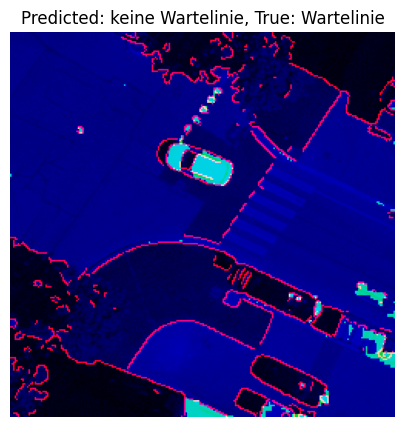

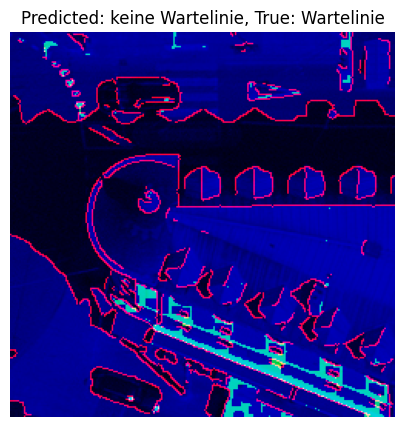

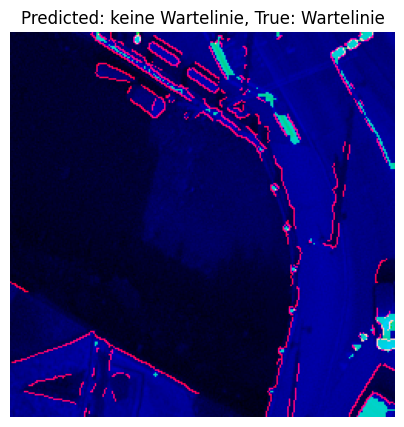

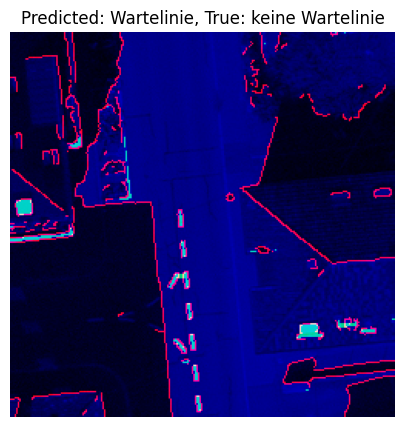

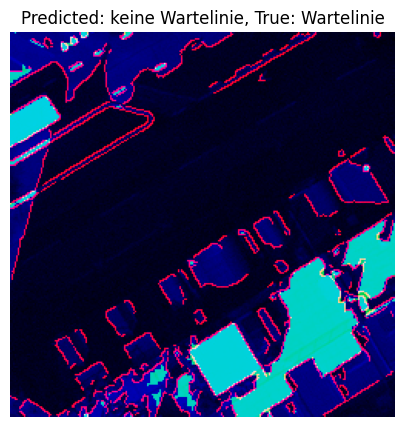

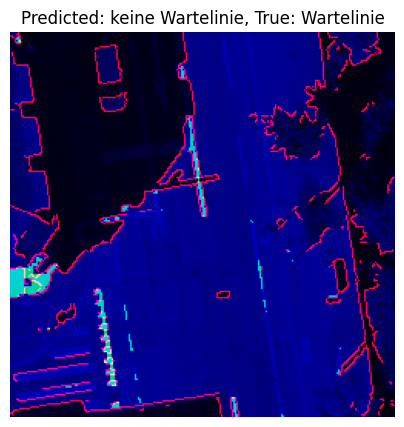

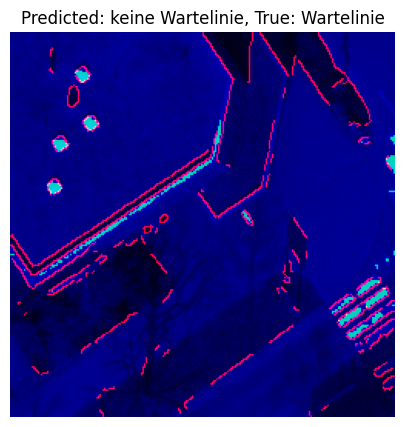

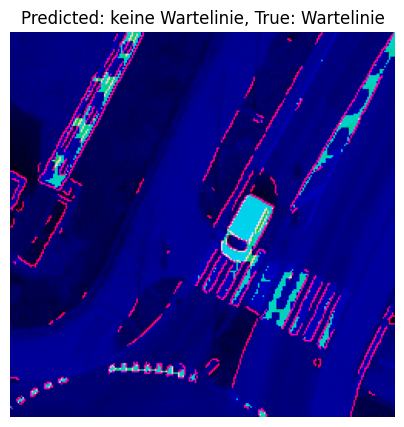

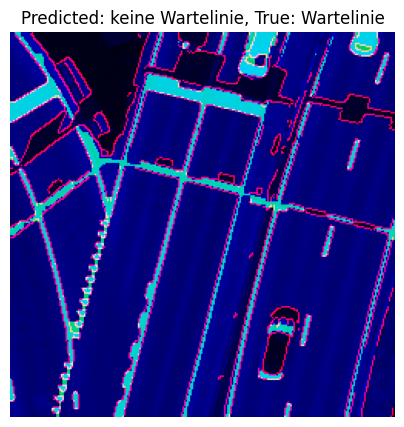

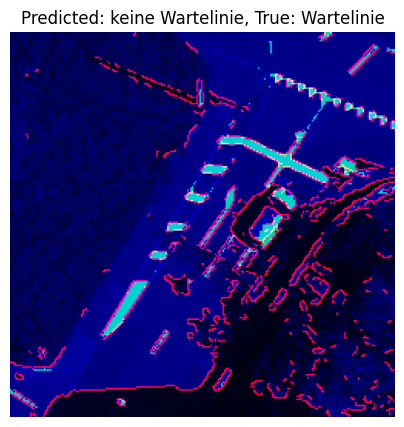

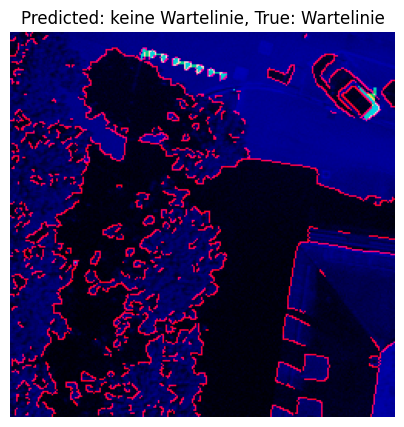

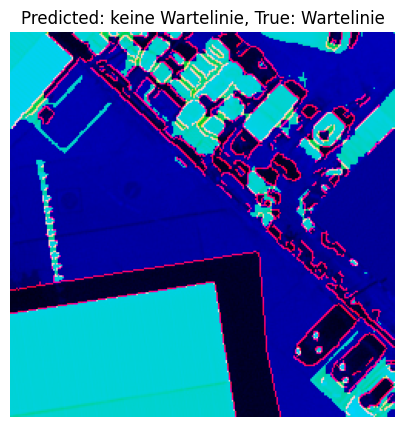

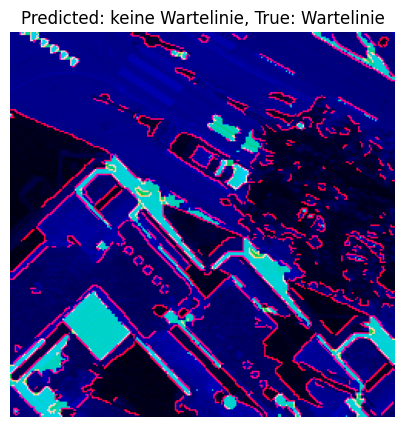

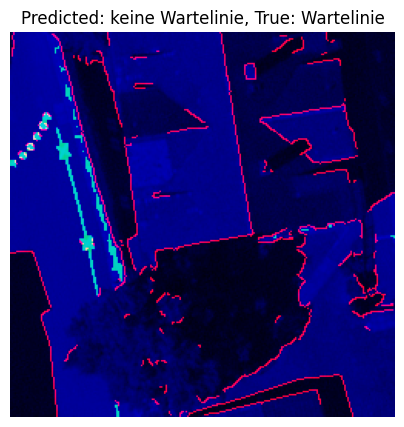

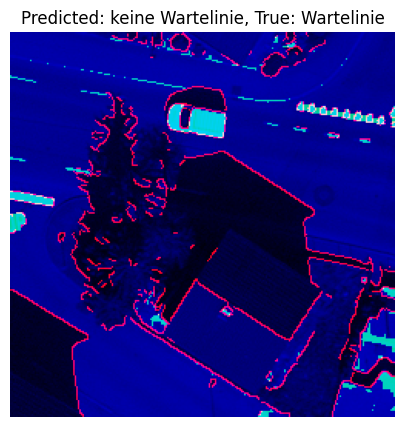

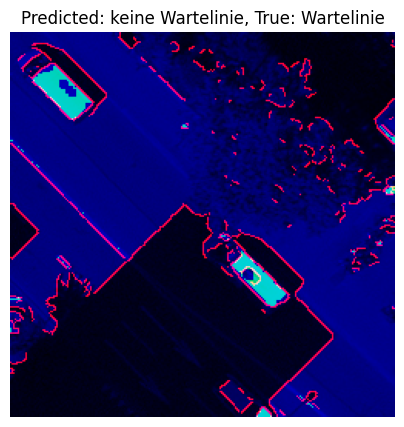

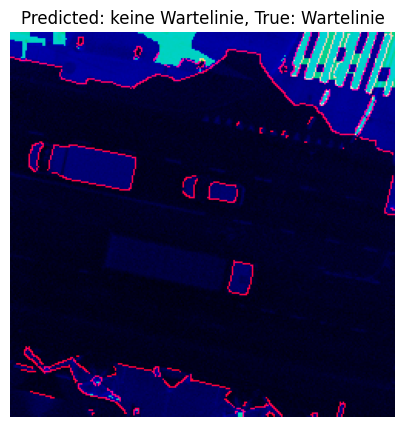

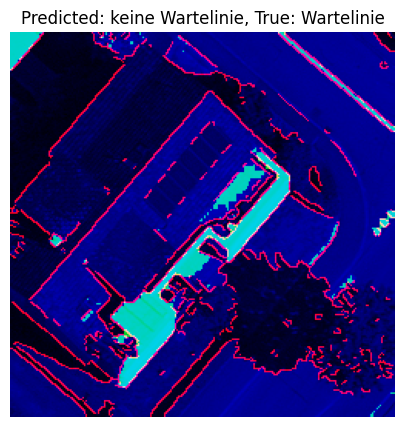

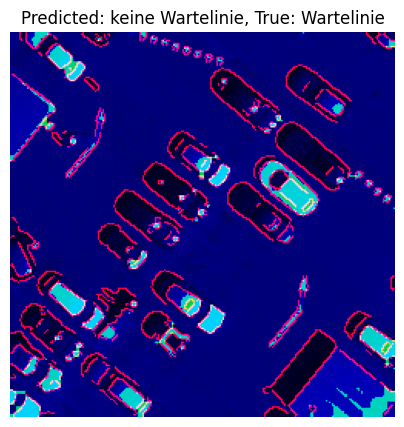

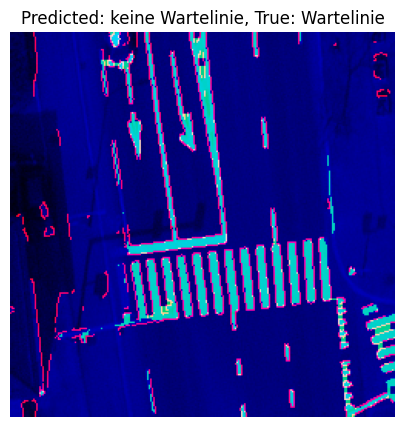

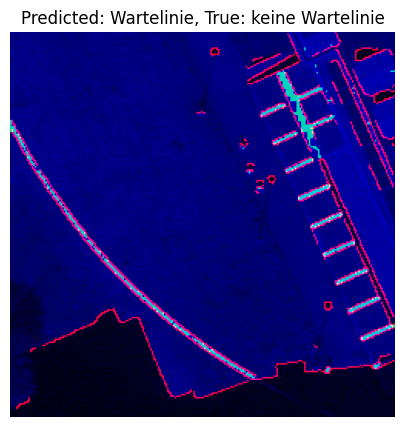

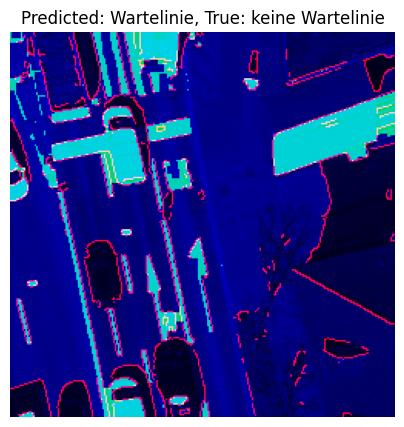

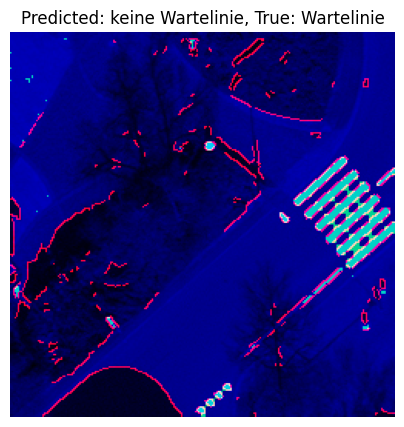

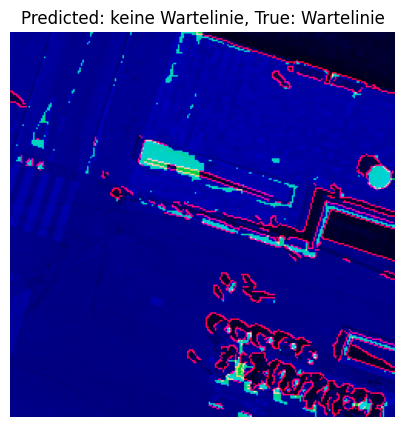

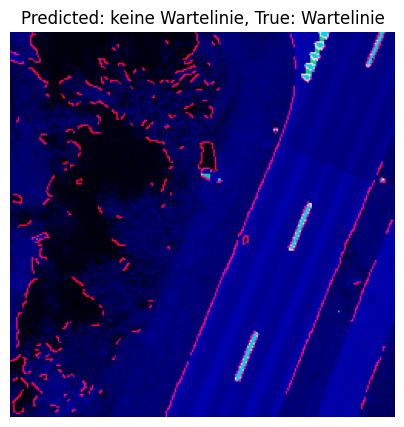

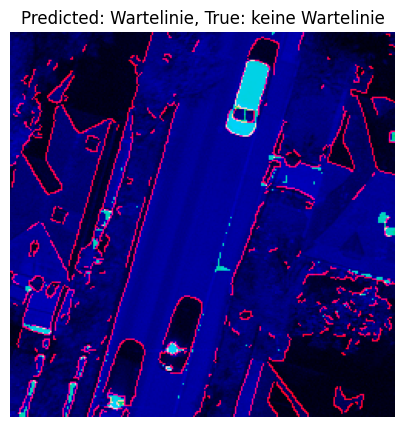

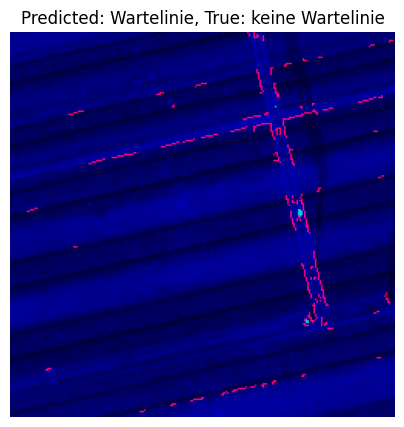

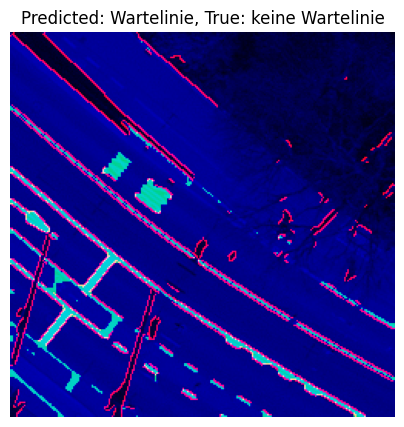

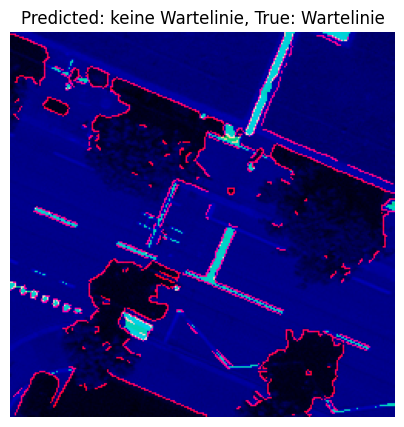

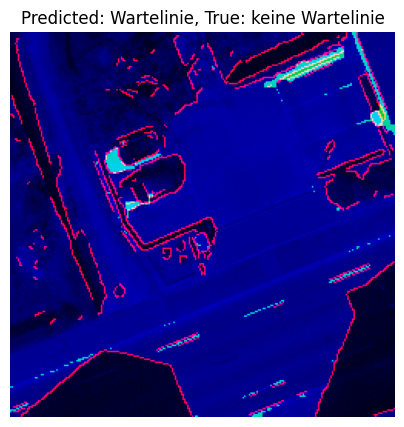

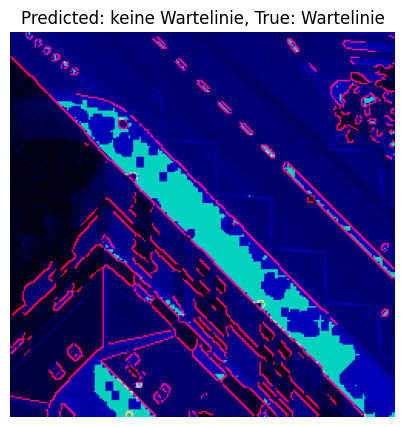

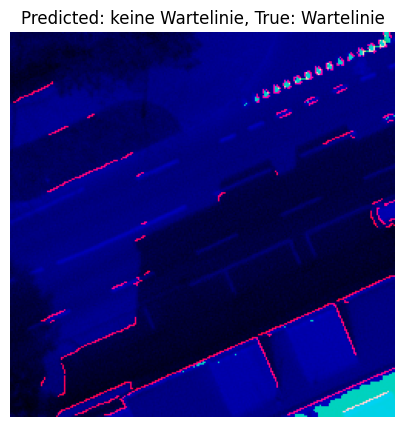

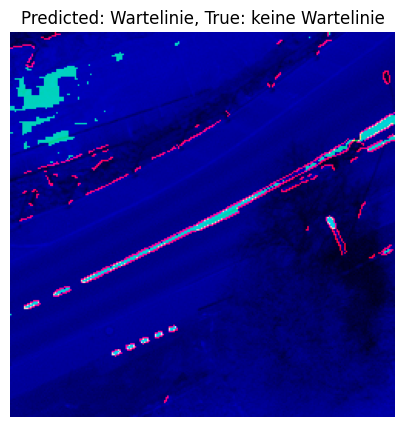

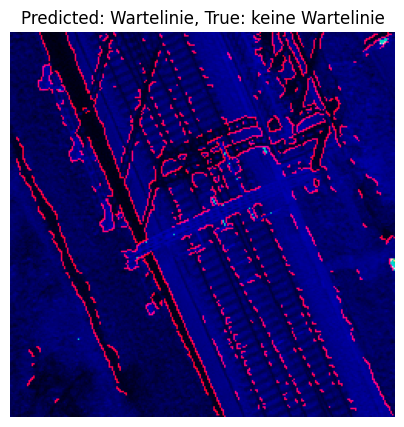

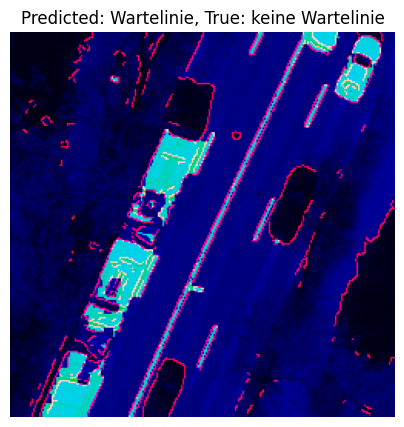

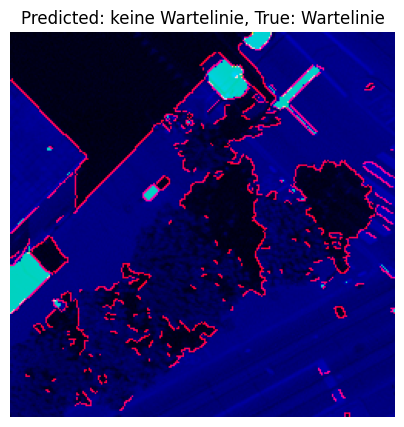

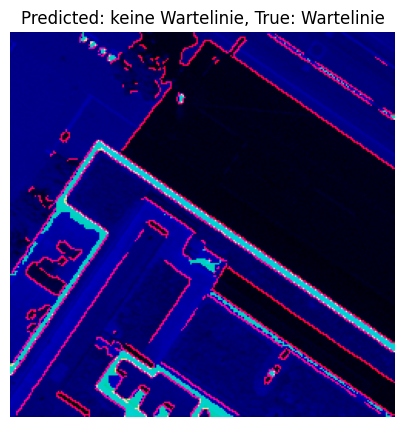

In [33]:
predictions_class_indices = (predictions.flatten() > 0.5).astype(int)

test_labels_class_indices = test_labels.flatten().astype(int)

incorrect_indices = [i for i, (true, pred) in enumerate(zip(test_labels_class_indices, predictions_class_indices)) if true != pred]

max_images_to_show = 40
shown_images = 0

for i in incorrect_indices:
    if shown_images < max_images_to_show:
        plt.figure(figsize=(5,5))
        plt.imshow(test_images[i], cmap='gray' if test_images[i].ndim == 2 else None)

        predicted_label = namelabels.get(predictions_class_indices[i], "Unknown")
        true_label = namelabels.get(test_labels_class_indices[i], "Unknown")
        plt.title(f'Predicted: {predicted_label}, True: {true_label}')
        plt.axis('off')
        plt.show()
        shown_images += 1
    else:
        break